In [1]:
library(arcgisbinding) ## The R-ArcGIS Bridge
library(ggplot2) ## R Package for Plotting Data
library(sf) ## Simple Features Package for Spatial Data Representation
library(spatstat) ## R Package for spatial statistical methods

*** Please call arc.check_product() to define a desktop license.
Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1
Loading required package: spatstat.data
Loading required package: nlme
Loading required package: rpart

spatstat 1.56-0       (nickname: 'Bondi Tram') 
For an introduction to spatstat, type 'beginner' 


Note: R version 3.5.1 (2018-07-02) is more than 9 months old; we strongly recommend upgrading to the latest version


In [2]:
arc.check_product()

product: ArcGIS Pro (12.8.0.28988)
license: Advanced
version: 1.0.1.244

In [3]:
## Define the directory to the Geodatabase in a variable called dir.gdb
dir.gdb <- 'C:/Users/orhu8849/Documents/ArcGIS/Projects/TreesEurope/TreesEurope.gdb'
## The name of the feature class containing Trees from Europe
fc.name <- 'EUForestspecies_XYTableToPoint'
## Describe the Tree Data
tree.meta <- arc.open(file.path(dir.gdb, fc.name))
print(tree.meta)

dataset_type    : FeatureClass
path            : C:/Users/orhu8849/Documents/ArcGIS/Projects/TreesEurope/TreesEurope.gdb/EUForestspecies_XYTableToPoint 
fields          : OBJECTID, Shape, X, Y, COUNTRY, SPECIES_NAME, DBH_1, DBH_2, 
fields          : NFI, FF, BS, EEO
extent          : xmin=1551500, ymin=843500, xmax=6444500, ymax=5355000
geometry type   : Point
WKT             : PROJCS["ETRS_1989_LAEA",GEOGCS["GCS_ETRS_1989",DATUM["D_ETRS...
WKID            : 3035 


In [4]:
## Get the data for European Trees into R
tree.arc <- arc.select(tree.meta)
head(tree.arc)


OBJECTID | X | Y | COUNTRY | SPECIES_NAME | DBH_1 | DBH_2 | NFI | FF | BS | EEO | 
|---|---|---|---|---|---|
| 1          | 4305500    | 2674500    | Austria    | Abies alba | -9999      | -9999      | -9999      |     1      | -9999      | 1          | 
| 2          | 4576500    | 2705500    | Austria    | Abies alba |     1      |     1      |     1      | -9999      | -9999      | 1          | 
| 3          | 4570500    | 2721500    | Austria    | Abies alba |     1      |     1      |     1      | -9999      | -9999      | 1          | 
| 4          | 4300500    | 2663500    | Austria    | Abies alba | -9999      |     1      |     1      | -9999      | -9999      | 1          | 
| 5          | 4610500    | 2811500    | Austria    | Abies alba | -9999      |     1      |     1      | -9999      | -9999      | 1          | 
| 6          | 4682500    | 2614000    | Austria    | Abies alba | -9999      | -9999      | -9999      | -9999      |     1      | 1          | 




In [5]:
## Convert the arc object to SF object for spatial analysis
tree.sf <- arc.data2sf(tree.arc)
head(tree.sf)

OBJECTID,X,Y,COUNTRY,SPECIES_NAME,DBH_1,DBH_2,NFI,FF,BS,EEO,geom
1,4305500,2674500,Austria,Abies alba,-9999,-9999,-9999,1,-9999,1,POINT (4305500 2674500)
2,4576500,2705500,Austria,Abies alba,1,1,1,-9999,-9999,1,POINT (4576500 2705500)
3,4570500,2721500,Austria,Abies alba,1,1,1,-9999,-9999,1,POINT (4570500 2721500)
4,4300500,2663500,Austria,Abies alba,-9999,1,1,-9999,-9999,1,POINT (4300500 2663500)
5,4610500,2811500,Austria,Abies alba,-9999,1,1,-9999,-9999,1,POINT (4610500 2811500)
6,4682500,2614000,Austria,Abies alba,-9999,-9999,-9999,-9999,1,1,POINT (4682500 2614000)


In [7]:
## Not an Assignment Task: Getting Unique Values
## Try unique function on the SF Object
#uniqueTrees <- unique(trees.nospatial["SPECIES_NAME"]) ## Not Working. 
? unique
## It seems unique requires a data.frame not a spatial data frame

In [8]:
## Remove the Spatial Component (Geometry) of SF Object and Create a Generic Data Frame
trees.nospatial <- data.frame(tree.sf)
## Use Unique Function to get Unique Values
uniqueTrees <- unique(trees.nospatial["SPECIES_NAME"])
## Print the number of Unique Species
print(paste0(dim(uniqueTrees)[1], ' number of tree species exist'))

[1] "242 number of tree species exist"


In [9]:
## Even a Simpler Way to do it
tree.table <- table(tree.sf$SPECIES_NAME)
tree.table


              Abies alba        Abies cephalonica            Abies grandis 
                    9383                        7                      436 
      Abies nordmanniana            Abies pinsapo            Abies procera 
                     315                       47                      431 
         Acacia dealbata       Acacia melanoxylon           Acer campestre 
                      38                       48                     5781 
       Acer cappadocicum      Acer monspessulanum             Acer negundo 
                      19                      716                      204 
             Acer opalus         Acer platanoides      Acer pseudoplatanus 
                    1009                     2096                    12412 
        Acer saccharinum           Acer tataricum   Aesculus hippocastanum 
                      16                      173                      310 
     Ailanthus altissima         Alnus alnobetula            Alnus cordata 
           

### Going Back Spatial Patterns of Tree Occurence


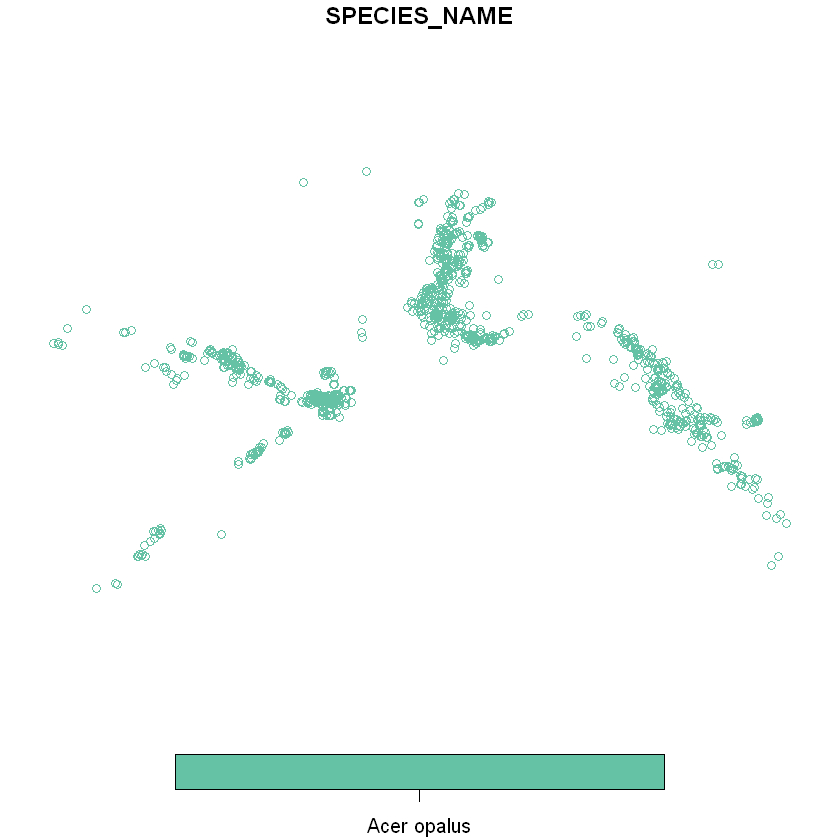

In [10]:
my.species <- 'Acer opalus' ## I pasted this species from the table above
ind <- tree.sf$SPECIES_NAME==my.species ## This is a logical index (you can print it if you want to)
plot(tree.sf[ind,'SPECIES_NAME']) ## I want a spatial plot of my species

In the plot above, I can see some clusters. If I squint I can see 3 big clusters, if I open my eyes a bit the fourth cluster in south-west (bottom left) emerges. How I can define these numerically? Let's calculate the nearest distance, the same nearest distance idea introduced in the lecture.

In [11]:
my.tree <- tree.sf[ind,] ## Get Acer Opalus and the all columns of the original dataset
#dists <- nndist(my.tree) ## This did not work, what do we do when things that don't work?
? nndist

The doc above tells me that `nndist` expects "Arguments specifying the locations of a set of points. " This means coordinates, now that I know I have an SF object, how do I get the coordinates. 

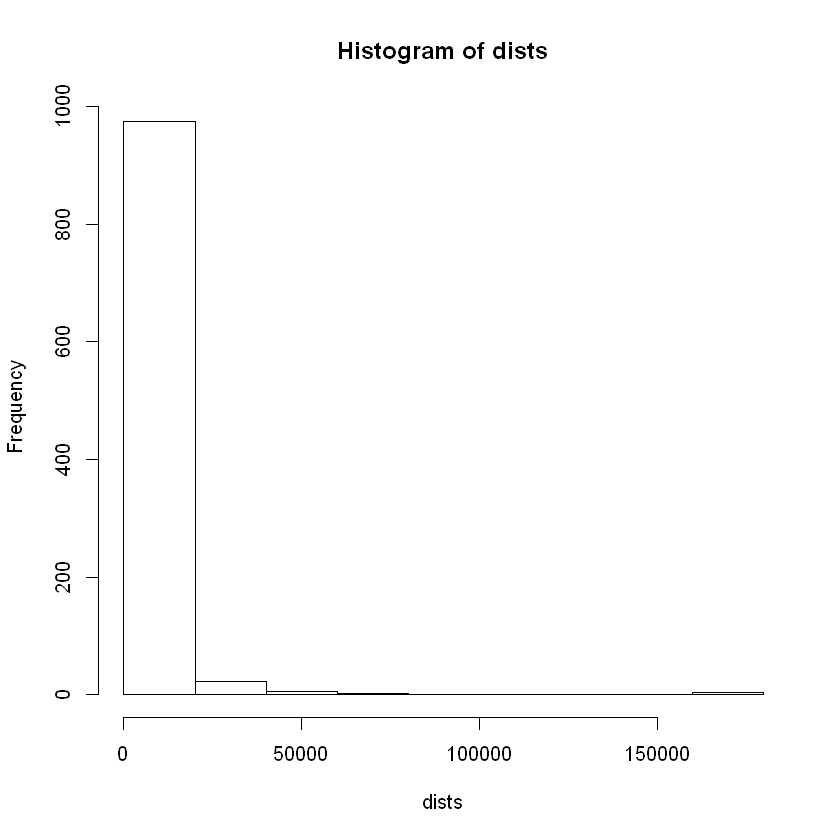

In [12]:
my.tree.locs <- st_coordinates(my.tree) ## Google told me I can use this function for getting coordinates of an sf object
dists <-nndist(my.tree.locs, k=1) ## We need distances to the next nearest neighbor (k=1)
hist(dists)

Here, small distance correspond to distance at which points are clustered. More rigorous methods of finding point pattern parameters, such as maximum likelihood, exists. Since we did not learn them in class, let's find an interaction distance from nndist.

In [13]:
d.inter <- median(dists) ## You can use the mean too. You can use any distance as a matter of fact.
d.inter

[1] 3605.551

### Fitting a Point Process Model

Let's fit a point process model to this dataset.



In [14]:
?Strauss

The document tells me that I need to define an interaction distance for a Strauss model. I will use `d.inter` the median distance to get to my nearest neighbor for that.

In [15]:
strauss.model <- Strauss(d.inter)## This defines a general Strauss point process model. Currently this model is not conditioned to data

In [16]:
## Using the Example in the Doc for Strauss I will use ppm to fit the model to data
#ppm(my.tree, ~1, model)

The function above is complaining about not having a point pattern. Going to the dock for spatstat package, I see that I can define it using `as.ppp` function. It needs coordinates for points and a bounding box `W`. I look for a way to get the bounding box for `my.tree` and see the function `st_bbox`.

In [17]:
bbox <- st_bbox(my.tree)
my.tree.locs <- st_coordinates(my.tree)
my.tree.ppp <- as.ppp(my.tree.locs, W = bbox)
my.tree.ppp

Planar point pattern: 1009 points
window: rectangle = [2954500, 4900000] x [1652500, 2759500] units

In [18]:
fitted.model <- ppm(my.tree.ppp, ~1, strauss.model) # As per Strauss doc, ~1 implies we are fitting a point process model without a mark
fitted.model

Stationary Strauss process

First order term:  beta = 3.98842e-10

Interaction distance:	3605.551
Fitted interaction parameter gamma:	 1.8086951

Relevant coefficients:
Interaction 
  0.5926057 

For standard errors, type coef(summary(x))

*** Model is not valid ***
*** Interaction parameters are outside valid range ***

### Extra: 
Here, every pattern contributes a factor of gamma to the overall density if are within interaction distance, overall every points contributes an amount beta (which is very small compared to our gamma). We would like gamma to be less than 1, so that entire point process is not only dominated by interaction terms and we can model some spatial randomness in the data. Here I will increase the interaction distance and retry the model.

In [19]:
strauss.model2 <- Strauss(d.inter*2)
fitted.model2 <- ppm(my.tree.ppp, ~1, strauss.model2) # Only difference compared to above is the model
fitted.model2

Stationary Strauss process

First order term:  beta = 3.510569e-10

Interaction distance:	7211.103
Fitted interaction parameter gamma:	 1.467842

Relevant coefficients:
Interaction 
  0.3837933 

For standard errors, type coef(summary(x))

*** Model is not valid ***
*** Interaction parameters are outside valid range ***

In [20]:
fitted.model2$coef[2] ## In R I see that the output contains coef attributes, it shows that second one is interaction.

Interaction 
  0.3837933

Impact of gamma went down but it is still high. What is happening here? The data has a strong trend. Take a look at the spatial distributions of the trees, they are observed frequently up north but I am using a Stationary Strauss process, thus I cannot model the **trend** in the data. That is fine for this simple model.

### Running the analysis above for every species
Analysis above can be performed for any species by simply changing the variable `my.species`. Next, I will set up an R loop to change this variable in a loop. Since we a list of unique species name under `uniqueTrees`, we can fit the model the same way to every tree type.

In [21]:
## Let's make sure the loop does what it is supposed to do
for (tree.name in uniqueTrees){
    print(tree.name)
}

  [1] "Abies alba"               "Acer campestre"          
  [3] "Acer negundo"             "Acer platanoides"        
  [5] "Acer pseudoplatanus"      "Ailanthus altissima"     
  [7] "Alnus alnobetula"         "Alnus glutinosa"         
  [9] "Alnus incana"             "Betula pendula"          
 [11] "Betula pubescens"         "Carpinus betulus"        
 [13] "Castanea sativa"          "Cornus mas"              
 [15] "Cornus sanguinea"         "Corylus avellana"        
 [17] "Crataegus monogyna"       "Euonymus europaeus"      
 [19] "Euonymus verrucosus"      "Fagus sylvatica"         
 [21] "Frangula alnus"           "Fraxinus angustifolia"   
 [23] "Fraxinus excelsior"       "Fraxinus ornus"          
 [25] "Ilex aquifolium"          "Juglans nigra"           
 [27] "Juglans regia"            "Juniperus communis"      
 [29] "Larix decidua"            "Ligustrum vulgare"       
 [31] "Picea abies"              "Pinus cembra"            
 [33] "Pinus mugo"               "Pinus 

In [22]:
## Let's update variables in this loop and run our analysis for every species. 
## Some of the species have only one observation and this might result in some model stability problems.
## Here I demo how to do this for the first 10 trees
for (tree.name in uniqueTrees$SPECIES_NAME[1:10]){
    print(paste0('Working on species: ', tree.name))
    ind <- tree.sf$SPECIES_NAME==tree.name
    ## Get the Tree Data
    my.tree <- tree.sf[ind,]
    my.tree.locs <- st_coordinates(my.tree)
    
    ## Find Nearest Distances
    dists <-nndist(my.tree.locs, k=1)
    d.inter <- median(dists)
    
    ## Define the Strauss Model
    strauss.model <- Strauss(d.inter)
    
    ## Create the PPP Object
    bbox <- st_bbox(my.tree)
    my.tree.locs <- st_coordinates(my.tree)
    my.tree.ppp <- as.ppp(my.tree.locs, W = bbox)
    
    ## Fit the Strauss Model
    fitted.model <- ppm(my.tree.ppp, ~1, strauss.model)
    
    ## 
    print(paste0('Interaction term for the model: ', fitted.model$coef[2]))
}

[1] "Working on species: Abies alba"


Warning message:
"data contain duplicated points"

[1] "Interaction term for the model: 1.01628279366637"
[1] "Working on species: Acer campestre"
[1] "Interaction term for the model: 0.570890285504653"
[1] "Working on species: Acer negundo"


Warning message:
"glm.fit: algorithm did not converge"

[1] "Interaction term for the model: 0.579425754405931"
[1] "Working on species: Acer platanoides"
[1] "Interaction term for the model: 0.721090473152732"
[1] "Working on species: Acer pseudoplatanus"
[1] "Interaction term for the model: 0.759496675005038"
[1] "Working on species: Ailanthus altissima"


Warning message:
"glm.fit: algorithm did not converge"

[1] "Interaction term for the model: 1.08295461118149"
[1] "Working on species: Alnus alnobetula"


Warning message:
"glm.fit: algorithm did not converge"

[1] "Interaction term for the model: 1.42047382077148"
[1] "Working on species: Alnus glutinosa"
[1] "Interaction term for the model: 0.658835103132428"
[1] "Working on species: Alnus incana"
[1] "Interaction term for the model: 1.09364626701221"
[1] "Working on species: Betula pendula"


Warning message:
"data contain duplicated points"

[1] "Interaction term for the model: 0.99465356620667"
